In [1]:
# imports
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore
import seaborn as sns
from torchvision.models.feature_extraction import create_feature_extractor

device = 'cpu' # mps out of memory

In [2]:
# load two models for comparison
from torchvision.models import resnet18, googlenet, ResNet18_Weights, GoogLeNet_Weights

# resnet18
rw = ResNet18_Weights.DEFAULT
preprocess = rw.transforms()
rw = resnet18(weights=rw).to(device).eval()
rf = create_feature_extractor(rw, {'avgpool': 'pen_feat'})
# googlenet
gw = GoogLeNet_Weights.DEFAULT
gw = googlenet(weights=gw).to(device).eval()
gf = create_feature_extractor(gw, {'avgpool': 'pen_feat'})

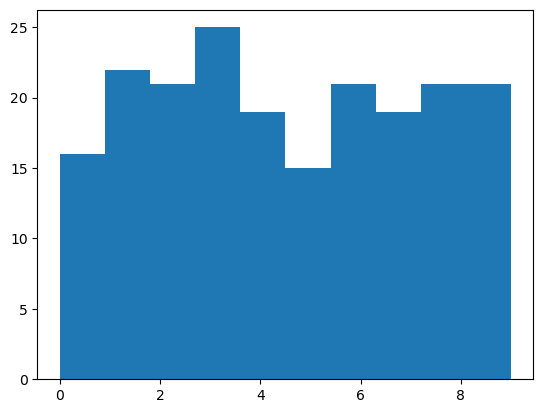

In [3]:
# preprocess data
preprocess = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    preprocess
])

# load dataset for stimuli
data = datasets.MNIST(
    root = './data',
    train = False,
    download=True,
    transform=preprocess
)

# select 200 random stimuli
torch.manual_seed(1337)
idx = torch.randint(0, 10000, (200,))
stimuli = {i: data.__getitem__(idx[i]) for i in range(len(idx))}
images = [stimuli[i][0] for i in range(len(stimuli))]
labels = [stimuli[i][1] for i in range(len(stimuli))]
images_tensor, labels_tensor = torch.stack(images).to(device), torch.tensor(labels)
# show labels histogram
plt.hist(labels)
plt.show()

In [4]:
# get activations from each model
r_act = rf(images_tensor)['pen_feat']
g_act = gf(images_tensor)['pen_feat']

In [5]:
activations = {
    'resnet': r_act.view(200,512).to(device).detach(),
    'googlenet': g_act.view(200,1024).to(device).detach()
}

In [6]:
# build RDMs via euclidean distance

# example with two stimuli
x = activations['resnet'][0]
y = activations['resnet'][1]

d_xy = torch.sqrt(torch.dot(x-y,x-y))
print(d_xy)

tensor(13.2850)


In [7]:
# now for all stimuli! (in matmul form)
def rdm(activations):
    A = torch.sum(torch.square(activations), dim=1, keepdim=True)
    rdm_sq = A + A.T - 2*torch.mm(activations,activations.T)
    return torch.sqrt(rdm_sq)

In [8]:
rdm_rn, rdm_gn = rdm(activations['resnet']), rdm(activations['googlenet'])
rdms = {
    'resnet' : rdm_rn,
    'googlenet': rdm_gn
}

In [14]:
print(rdms['resnet'])
print(f"ResNet activation variance: {activations['resnet'].var()}")

tensor([[1.1049e-02, 1.3285e+01, 9.3101e+00,  ..., 1.4382e+01, 1.3595e+01,
         1.0659e+01],
        [1.3285e+01, 1.5625e-02, 1.2361e+01,  ..., 1.3019e+01, 1.4339e+01,
         1.5598e+01],
        [9.3101e+00, 1.2361e+01,        nan,  ..., 1.4169e+01, 1.5761e+01,
         1.3992e+01],
        ...,
        [1.4382e+01, 1.3019e+01, 1.4169e+01,  ..., 2.4705e-02, 1.6780e+01,
         1.6380e+01],
        [1.3595e+01, 1.4339e+01, 1.5761e+01,  ..., 1.6780e+01, 0.0000e+00,
         1.6547e+01],
        [1.0659e+01, 1.5598e+01, 1.3992e+01,  ..., 1.6380e+01, 1.6547e+01,
         1.3532e-02]])
ResNet activation variance: 0.693601667881012


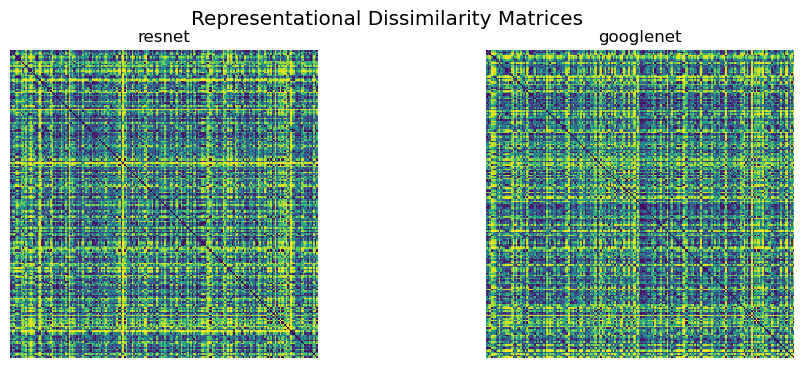

In [15]:
percentile_rdms = {}
for model in ['resnet', 'googlenet']:
    raw_rdm = rdms[model]
    raw_rdm = torch.nan_to_num(raw_rdm, nan=0.0)
    percentiles = percentileofscore(raw_rdm.flatten().detach().numpy(), raw_rdm.flatten().detach().numpy(), kind='rank')    
    percentile_rdms[model] = percentiles.reshape(raw_rdm.shape)

# Prepare plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot RDMs
with sns.plotting_context('notebook'):
    for ax, model in zip(axes, ['resnet', 'googlenet']):
        sns.heatmap(
            percentile_rdms[model],
            vmin=0,
            vmax=100,
            cmap='viridis',
            cbar=False,
            square=True,
            ax=ax
        )
        ax.set_title(model)
        ax.set_xticks([])
        ax.set_yticks([])

    # Add title
    fig.suptitle('Representational Dissimilarity Matrices')
    
    
    plt.subplots_adjust(wspace=0.05)
    plt.show()